In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/forest-cover-type-prediction/train.csv.zip
/kaggle/input/forest-cover-type-prediction/sampleSubmission.csv
/kaggle/input/forest-cover-type-prediction/sampleSubmission.csv.zip
/kaggle/input/forest-cover-type-prediction/test3.csv
/kaggle/input/forest-cover-type-prediction/train.csv
/kaggle/input/forest-cover-type-prediction/test.csv
/kaggle/input/forest-cover-type-prediction/test.csv.zip


In [2]:
data_path = '/kaggle/input/forest-cover-type-prediction/'
train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

In [3]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Id                                  15120 non-null  int64
 1   Elevation                           15120 non-null  int64
 2   Aspect                              15120 non-null  int64
 3   Slope                               15120 non-null  int64
 4   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 5   Vertical_Distance_To_Hydrology      15120 non-null  int64
 6   Horizontal_Distance_To_Roadways     15120 non-null  int64
 7   Hillshade_9am                       15120 non-null  int64
 8   Hillshade_Noon                      15120 non-null  int64
 9   Hillshade_3pm                       15120 non-null  int64
 10  Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 11  Wilderness_Area1                    15120 non-null  int64
 12  Wild

# train.info()와 test.info()를 통해 데이터의 전체 구조, 각 컬럼의 데이터 타입 및 결측값 유무를 확인.

# 학습 데이터
- 행: 15120, 열: 56, 타입: 모두 int64

# 테스트 데이터
- 행: 565892 열: 55, 타입: 모두 int64
- Cover_Type 없음

In [4]:
train.isnull().sum()
test.isnull().sum()

Id                                    0
Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0


# 결측값 확인
- 두 데이터 모두 결측값 없음

In [5]:
# Train, Test 레코드 수, 피처 수 출력
print("Train data")
print("Train 레코드 수:", train.shape[0])
print("Train 피처 수:", train.shape[1])
print("Test data")
print("Test 레코드 수:", test.shape[0])
print("Test 피처 수:", test.shape[1])

# 용량 출력
train_size = os.path.getsize(data_path + 'train.csv')
test_size = os.path.getsize(data_path + 'test.csv')

print("Train 용량: " + str(train_size) + "byte")
print("Test 용량: " + str(test_size) + "byte")

Train data
Train 레코드 수: 15120
Train 피처 수: 56
Test data
Test 레코드 수: 565892
Test 피처 수: 55
Train 용량: 2029405byte
Test 용량: 75965596byte


# 데이터 양
- info 결과와 같음

# Train data
- 레코드 수: 15120, 피처 수: 56, 용량: 2029405byte

# Test data
- 레코드수: 565892, 피처 수: 55, 용량: Test 용량: 75965596byte

In [6]:
feature_summary = pd.DataFrame({
    '데이터 유형': train.dtypes,
    '결측치 개수': train.isnull().sum(),
    '고윳값 개수': train.nunique(),
}).reset_index().rename(columns={'index':'Feature'})


# Feature & Target 값의 이해
- 데이터 유형: 해당 컬럼의 데이터 타입 정보
- 결측치 개수: 각 피처에 존재하는 결측치의 수
- 고윴값 개수: 해당 피처에서 유일하게 존재하는 값의 수

In [7]:
def classify_feature(name):
    if name == 'Cover_Type':
        return '타겟'
    elif 'Wilderness_Area' in name or 'Soil_Type' in name:
        return '범주형'
    else:
        return '수치형'

feature_summary['데이터 종류'] = feature_summary['Feature'].apply(classify_feature)

numeric_features = feature_summary[feature_summary['데이터 종류'] == '수치형']['Feature'].tolist()
categorical_features = feature_summary[feature_summary['데이터 종류'] == '범주형']['Feature'].tolist()

# 피처 분류: 수치형, 범주형, 타켓
- 타켓: Cover_Type(예측해야 할 값)
- 범주형: Wilderness_Area 및 Soil_Type 관련 컬럼(0 또는 1) - 이미 원-핫 인코딩이 되어있음(데이터 인코딩 생략)
- 수치형: 나머지 피처들은 연속적인 값을 가지는 수치형으로 분류

In [8]:
# 의미 사전 정의
feature_meaning = {
    'Elevation': '고도 (단위: m)',
    'Aspect': '방위각 (단위: 도, 북쪽=0°)',
    'Slope': '경사도 (단위: 도)',
    'Horizontal_Distance_To_Hydrology': '수면과의 수평 거리',
    'Vertical_Distance_To_Hydrology': '수면과의 수직 거리',
    'Horizontal_Distance_To_Roadways': '도로와의 수평 거리',
    'Hillshade_9am': '오전 9시 일조량 지수 (0~255)',
    'Hillshade_Noon': '정오 일조량 지수 (0~255)',
    'Hillshade_3pm': '오후 3시 일조량 지수 (0~255)',
    'Horizontal_Distance_To_Fire_Points': '화재 발생 지점과의 수평 거리',
    'Cover_Type': '예측 대상: 산림 덮개 유형 (1~7)',
}

# 의미 추출 함수
def get_meaning(feature):
    if feature in feature_meaning:
        return feature_meaning[feature]
    elif 'Wilderness_Area' in feature:
        return '야생보호구역 여부 (4개 컬럼, 0=없음, 1=있음)'
    elif 'Soil_Type' in feature:
        return '토양 유형 (40개 컬럼, 0=없음, 1=있음)'
    else:
        return '설명 없음'

# 의미 컬럼 추가
feature_summary['의미'] = feature_summary['Feature'].apply(get_meaning)

feature_summary

,Feature,데이터 유형,결측치 개수,고윳값 개수,데이터 종류,의미
0,Id,int64,0,15120,수치형,설명 없음
1,Elevation,int64,0,1665,수치형,고도 (단위: m)
2,Aspect,int64,0,361,수치형,"방위각 (단위: 도, 북쪽=0°)"
3,Slope,int64,0,52,수치형,경사도 (단위: 도)
4,Horizontal_Distance_To_Hydrology,int64,0,400,수치형,수면과의 수평 거리
5,Vertical_Distance_To_Hydrology,int64,0,423,수치형,수면과의 수직 거리
6,Horizontal_Distance_To_Roadways,int64,0,3250,수치형,도로와의 수평 거리
7,Hillshade_9am,int64,0,176,수치형,오전 9시 일조량 지수 (0~255)
8,Hillshade_Noon,int64,0,141,수치형,정오 일조량 지수 (0~255)
9,Hillshade_3pm,int64,0,247,수치형,오후 3시 일조량 지수 (0~255)


# 데이터 셋의 각 피처에 대해 다음 정보를 정리한 테이블 생성
- 데이터 유형
- 결측치 개수
- 고윳값 개수
- 데이터 종류
- 의미

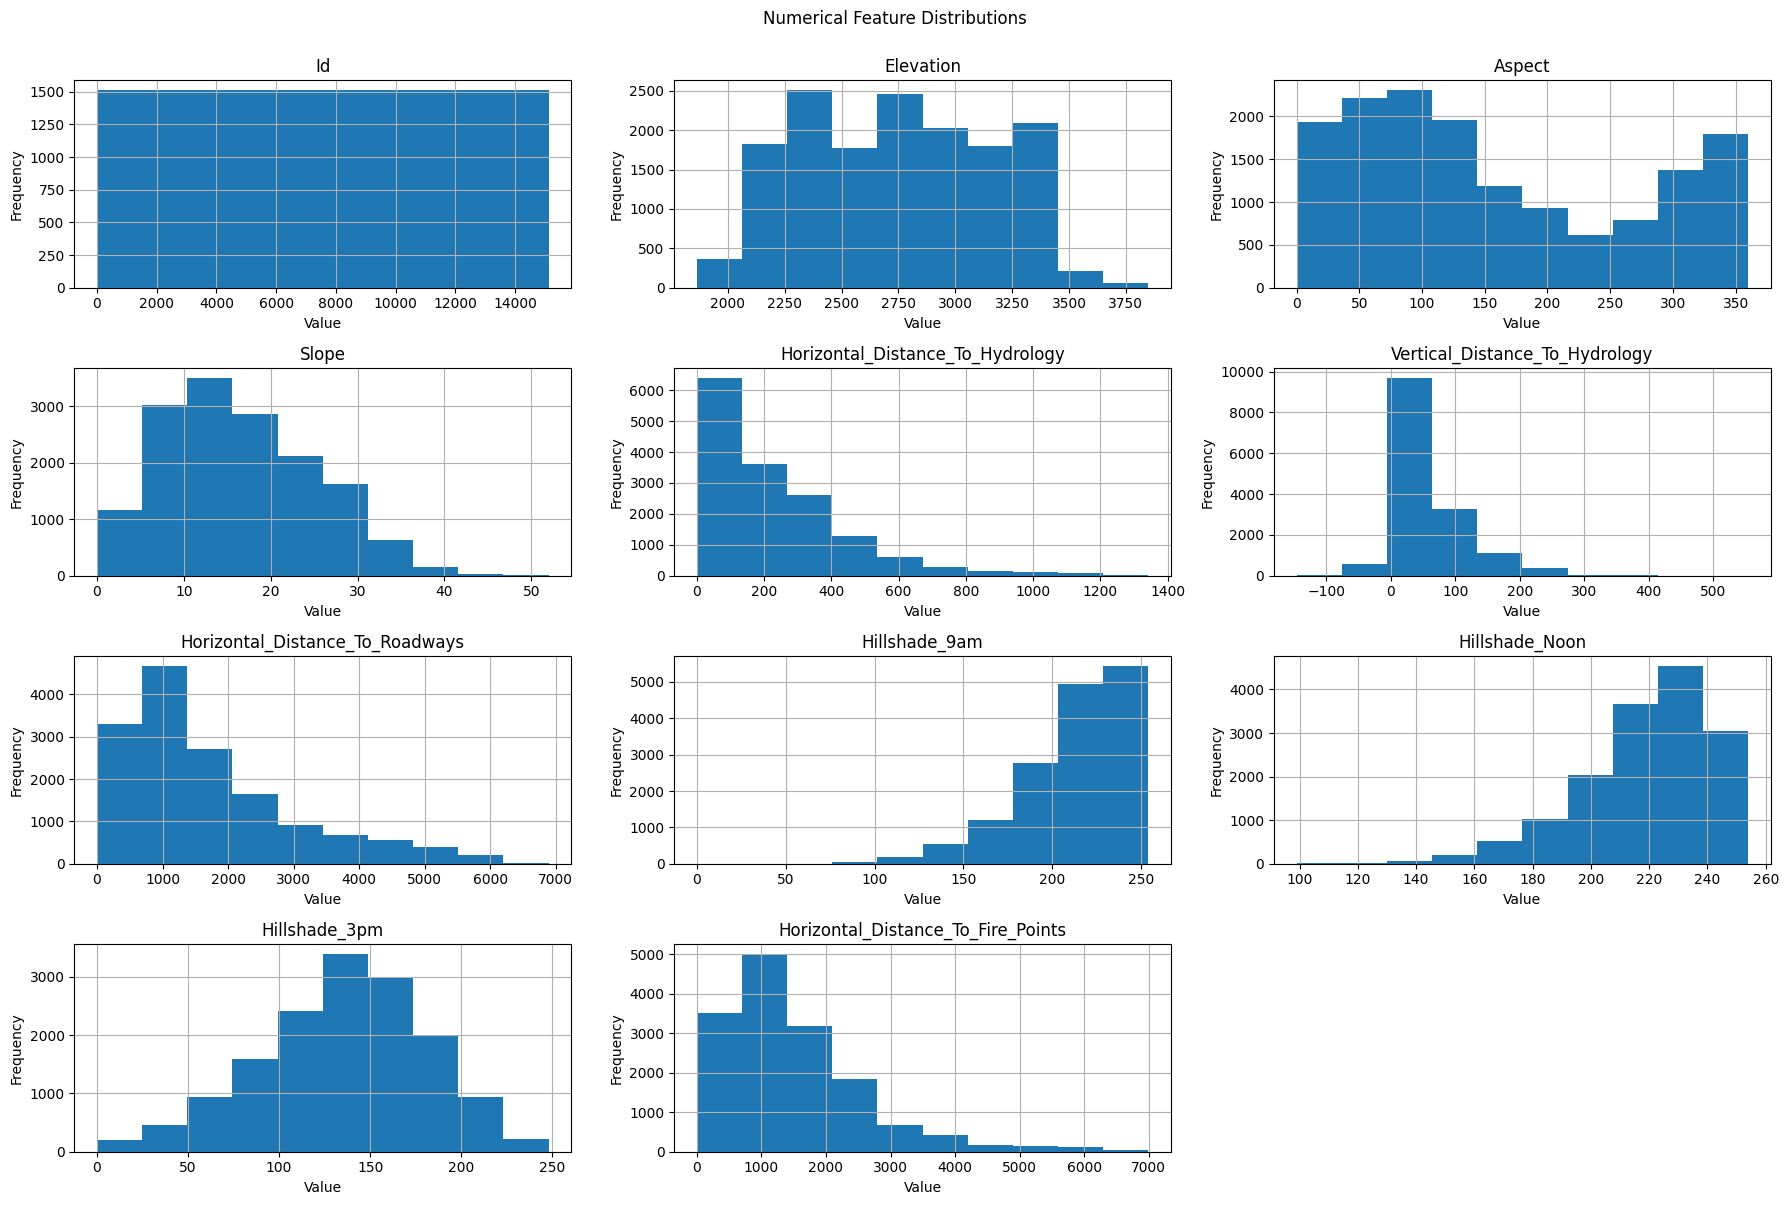

In [9]:
import matplotlib.pyplot as plt

fig = train[numeric_features].hist(figsize=(18, 12))
plt.suptitle("Numerical Feature Distributions", y=1)

for ax in fig.flatten():
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()



# 전체 수치형 피처의 분포를 한눈에 파악하기 위한 히스토그램
- 각 피처의 값들이 어떤 분포를 보이는지 확인 가능하며 이상치나 비대칭 분포를 시각적으로 확인 가능
- x축은 해당 피처의 값 범위, y축은 등장 빈도


#

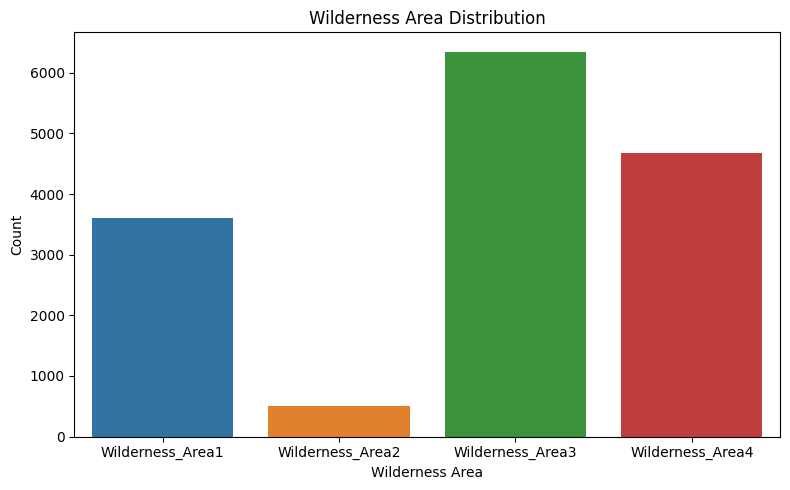

In [10]:
import seaborn as sns

wilderness_cols = [col for col in categorical_features if "Wilderness_Area" in col]
wilderness_counts = train[wilderness_cols].sum()

plt.figure(figsize=(8, 5))
sns.barplot(x=wilderness_counts.index, y=wilderness_counts.values)
plt.title("Wilderness Area Distribution")
plt.ylabel("Count")
plt.xlabel("Wilderness Area")
plt.tight_layout()
plt.show()


# Wilderness_Area 분포 시각화(Wilderness_Area에 속하는 샘플의 개수 시각화)
- 분포를 통해 각 구역의 데이터 수가 불균형하게 분포되어 있음을 확인

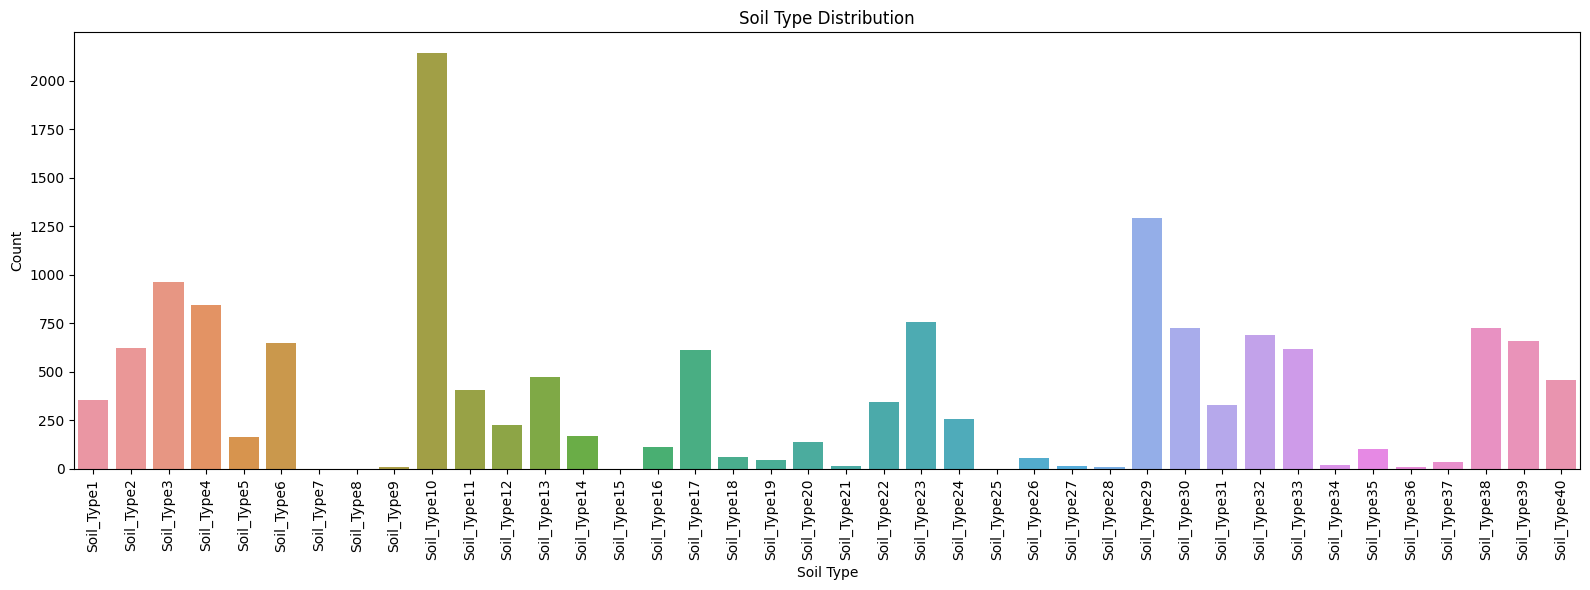

In [11]:
# Soil_Type 컬럼 리스트
soil_cols = [col for col in categorical_features if "Soil_Type" in col]
soil_counts = train[soil_cols].sum()

plt.figure(figsize=(16, 6))
sns.barplot(x=soil_counts.index, y=soil_counts.values)
plt.title("Soil Type Distribution")
plt.ylabel("Count")
plt.xlabel("Soil Type")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Soil Type 분포 시각화
- 각 샘플이 속한 토양의 유형을 나타냄
- 특정 Soil_Type에 샘플이 몰려있고 일부는 매우 적음(데이터 불균형)

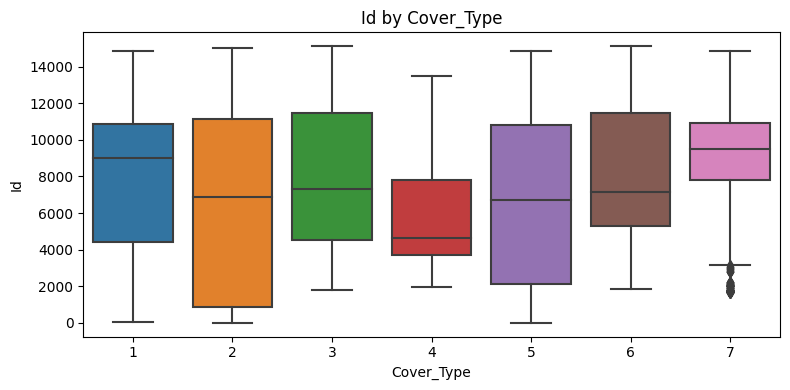

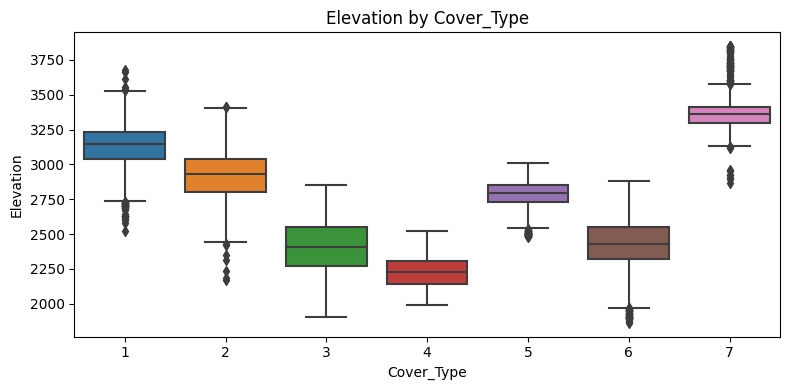

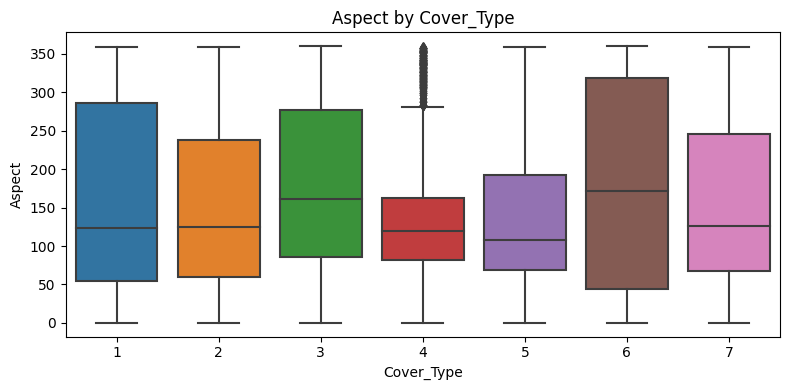

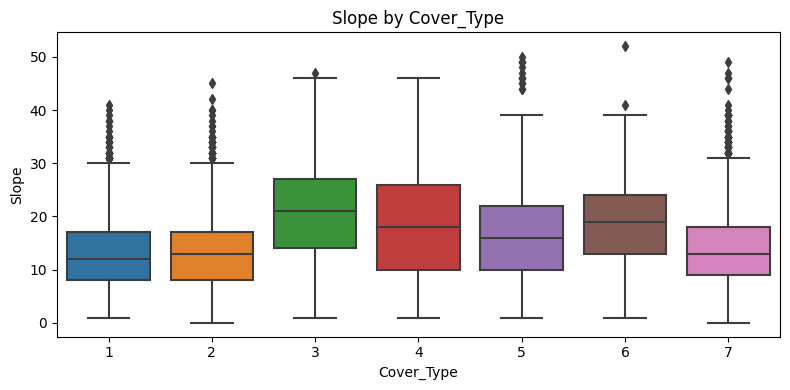

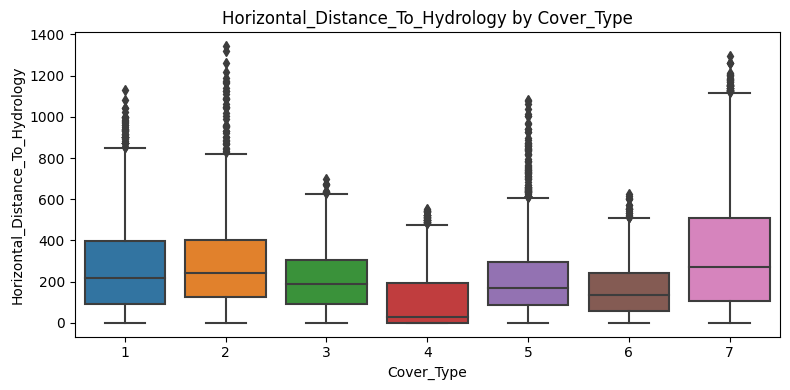

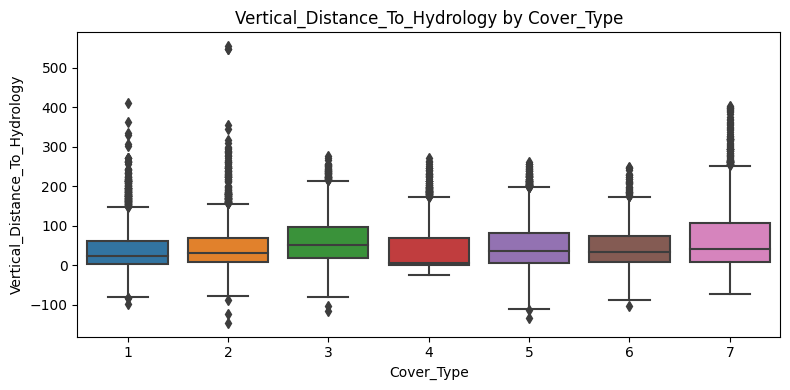

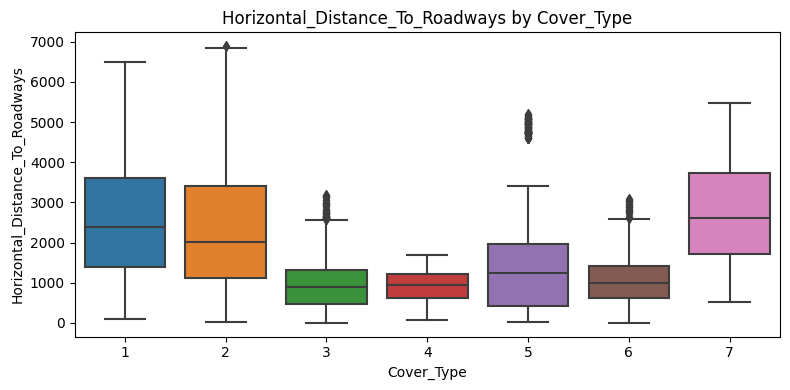

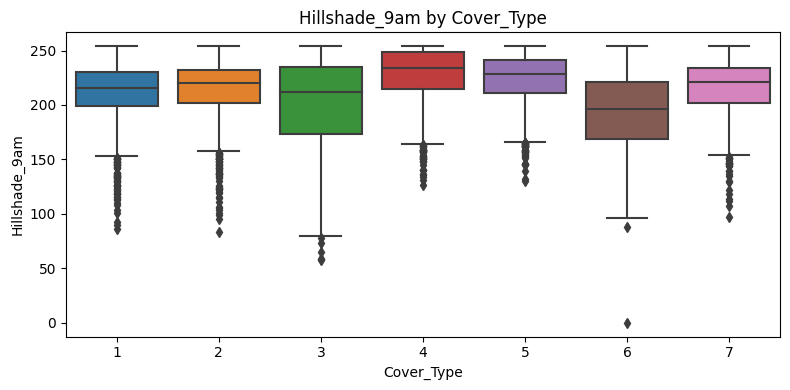

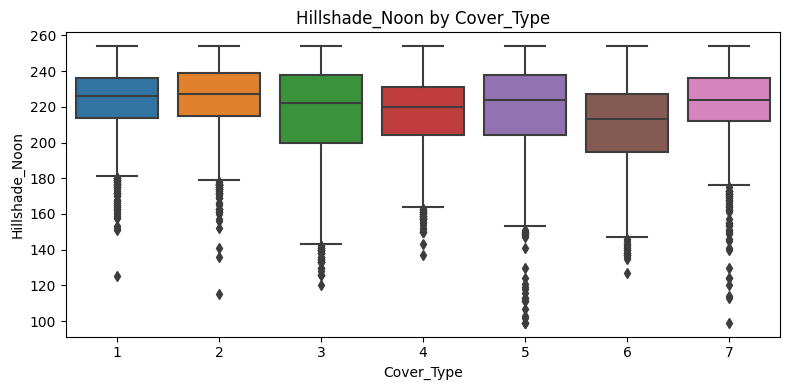

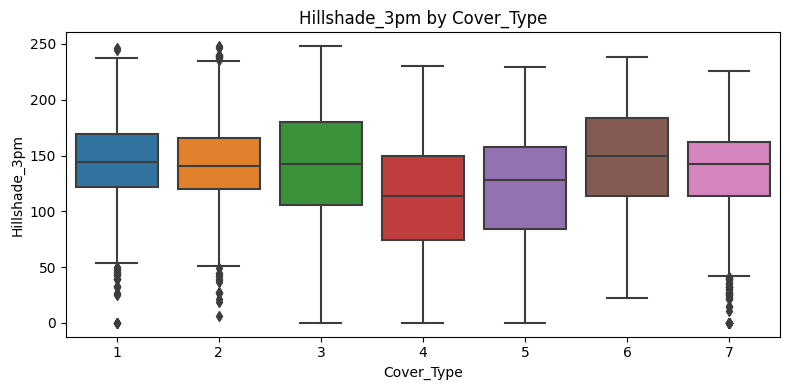

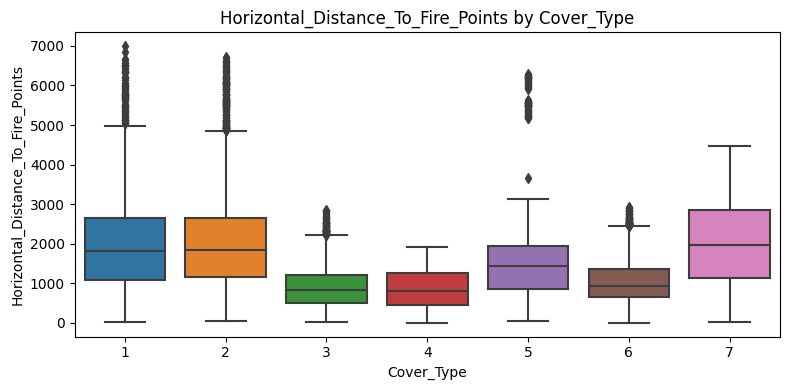

In [12]:
#수치형과 Cover_Type 관계 시각화 (Boxplot)
for col in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='Cover_Type', y=col, data=train)
    plt.title(f"{col} by Cover_Type")
    plt.tight_layout()
    plt.show()

# 수치형 변수와 Cover_Type 간의 관계
- 각 수치형 변수와 Cover_Type 간의 관계를 Boxplot으로 시각화
- 수치형 변수의 중앙값, IQR, 이상치 분포를 보여준다.

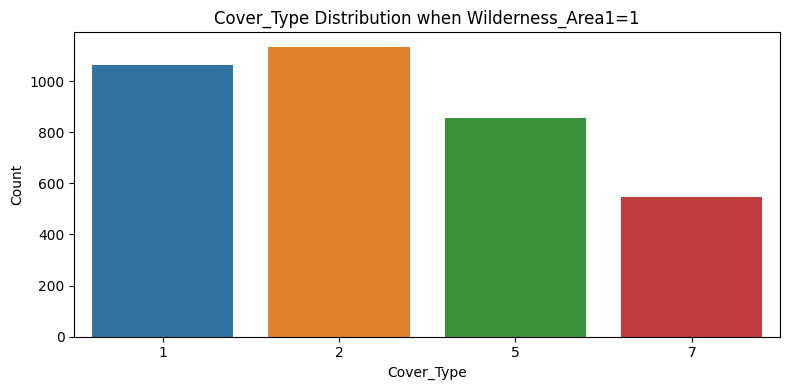

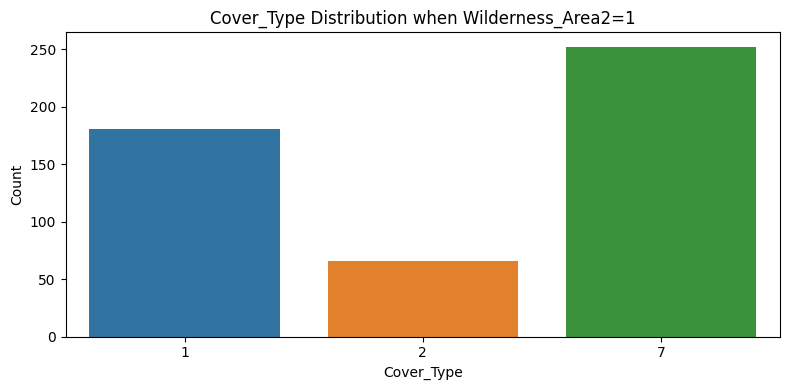

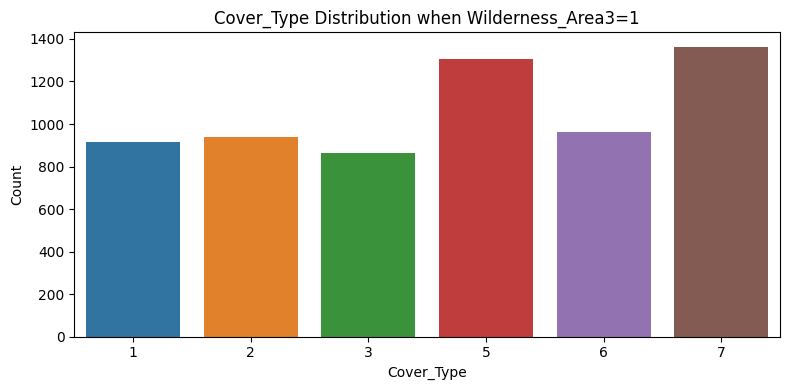

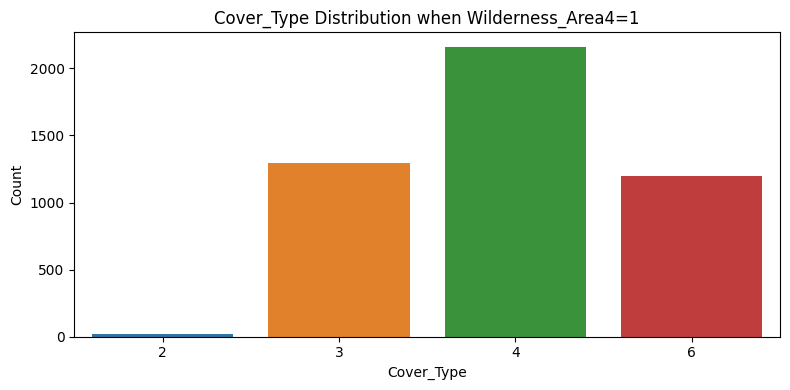

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Wilderness_Area 컬럼만 필터링
wilderness_cols = [col for col in categorical_features if "Wilderness_Area" in col]

# 각 One-Hot 컬럼에 대해 Cover_Type 분포 확인
for col in wilderness_cols:
    plt.figure(figsize=(8, 4))
    subset = train[train[col] == 1]  # 해당 지역인 경우만 선택
    sns.countplot(x='Cover_Type', data=subset)
    plt.title(f"Cover_Type Distribution when {col}=1")
    plt.xlabel("Cover_Type")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Wilderness Area와 Cover_Type간의 관계 분석
- 각 Wilderness_Area가 1인 경우에만 데이터를 필터링하여 Cover_Type의 분포를 확인

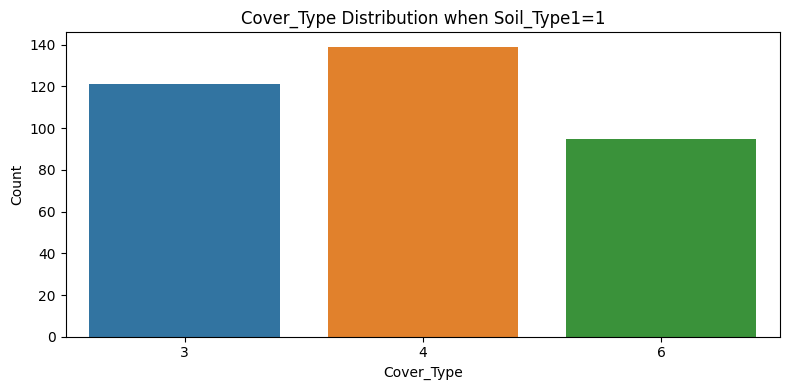

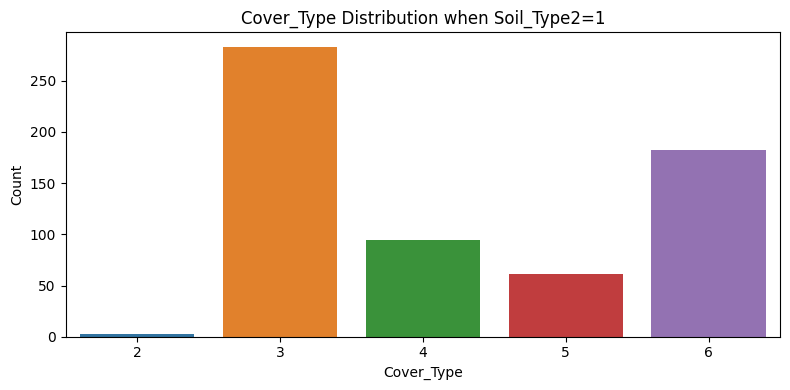

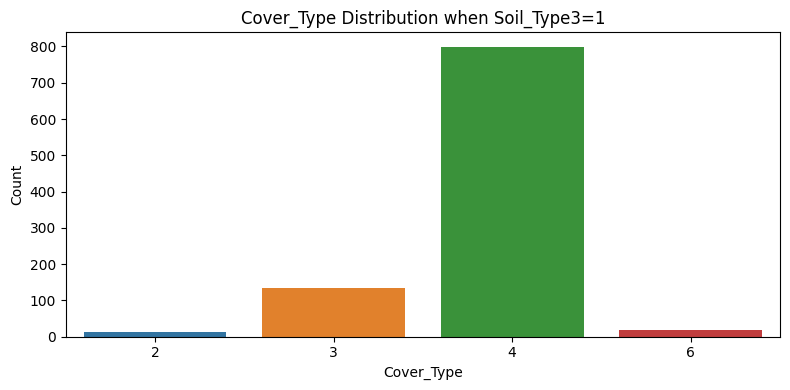

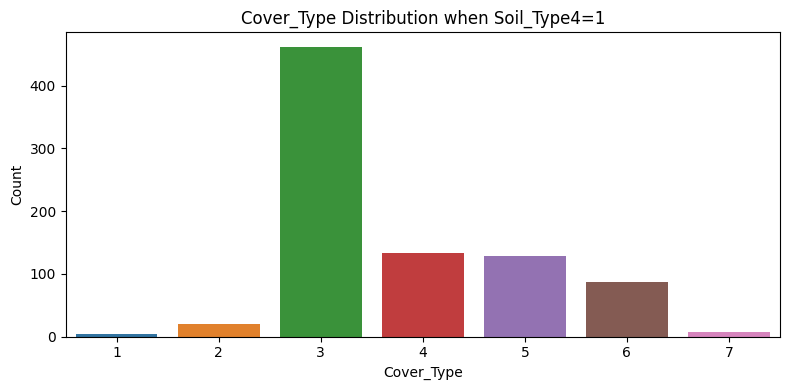

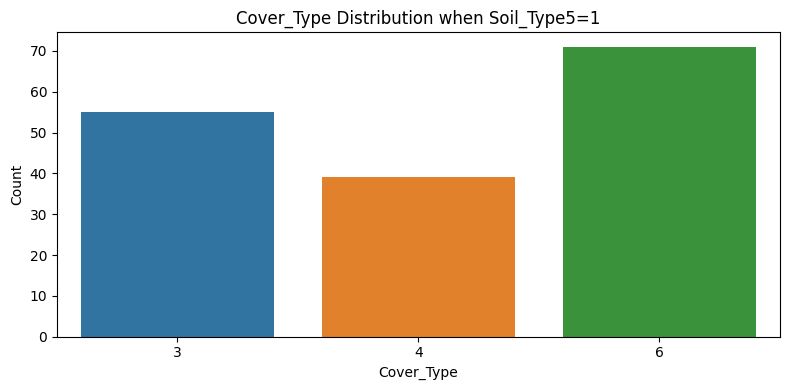

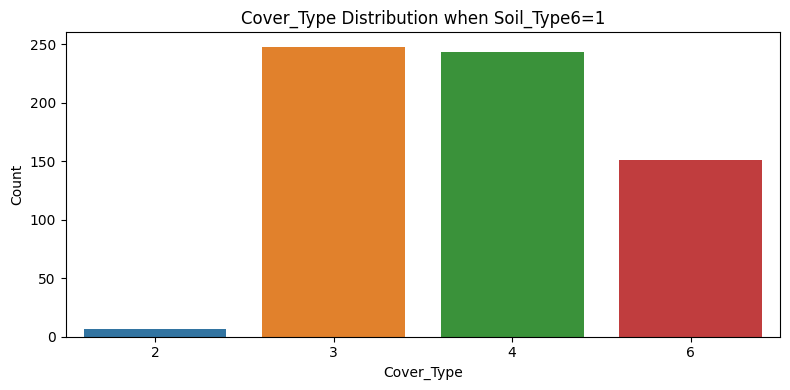

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)


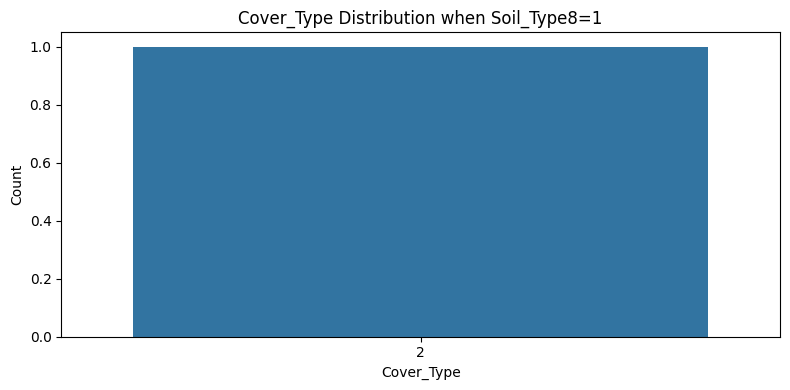

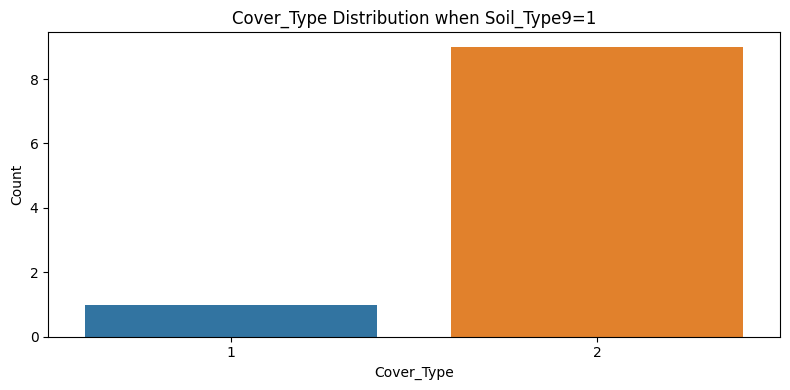

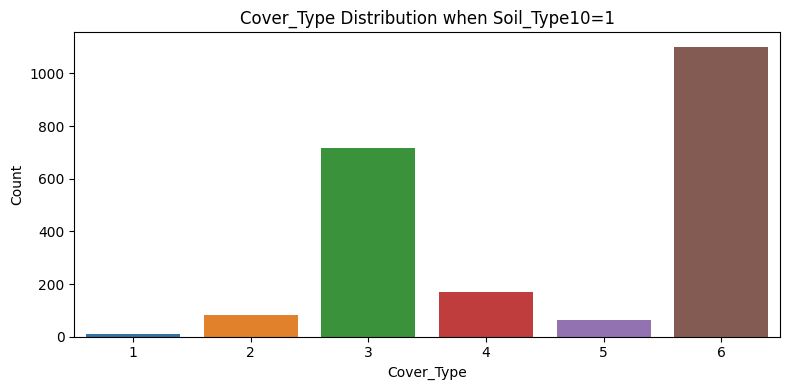

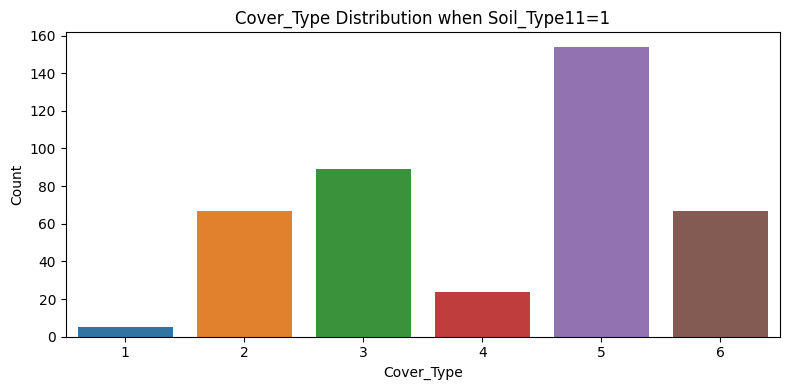

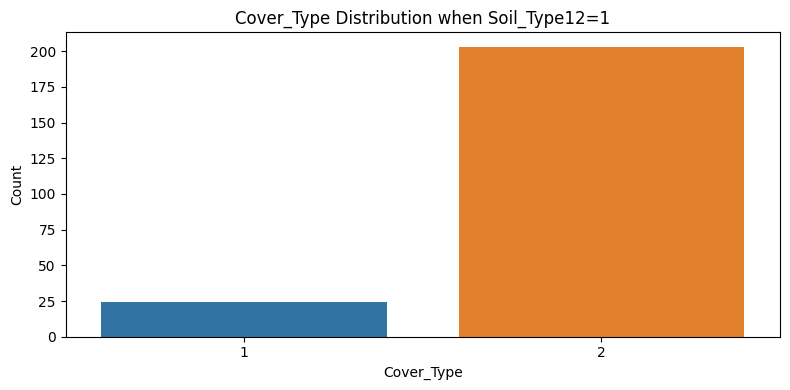

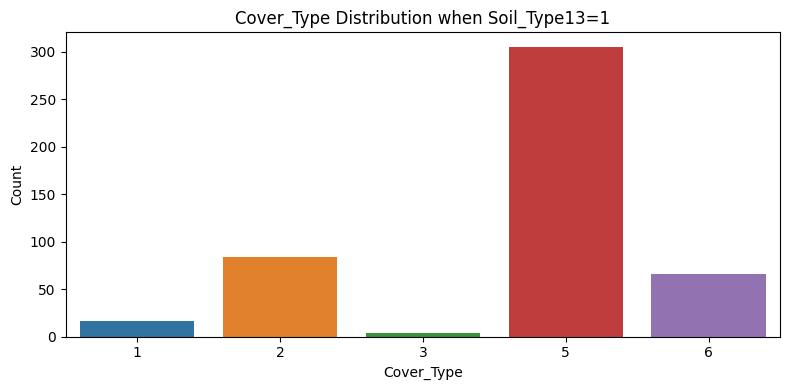

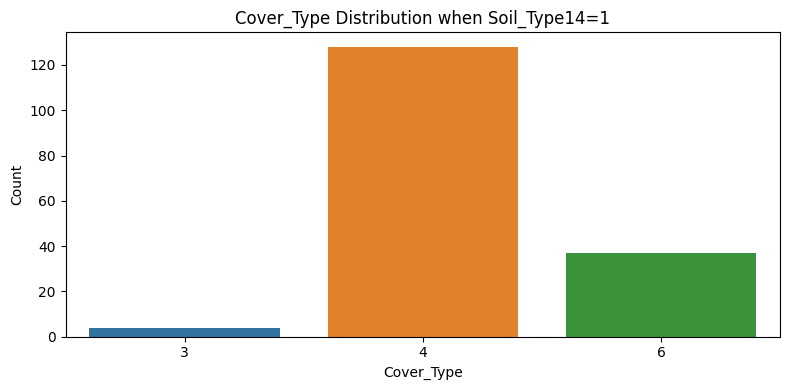

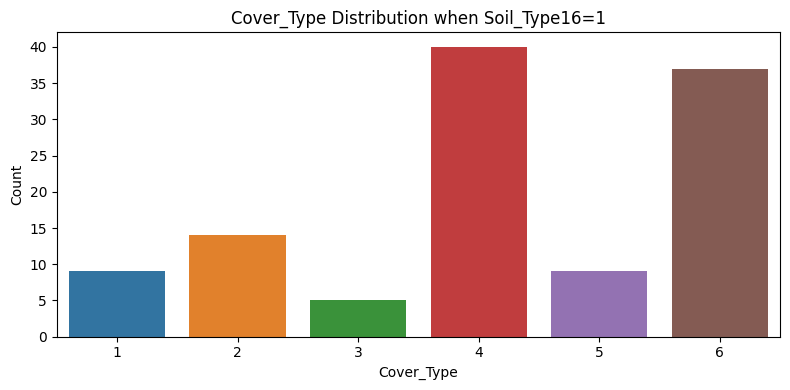

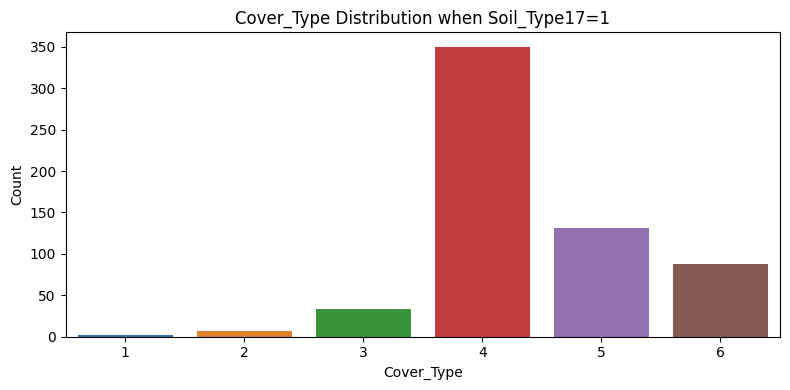

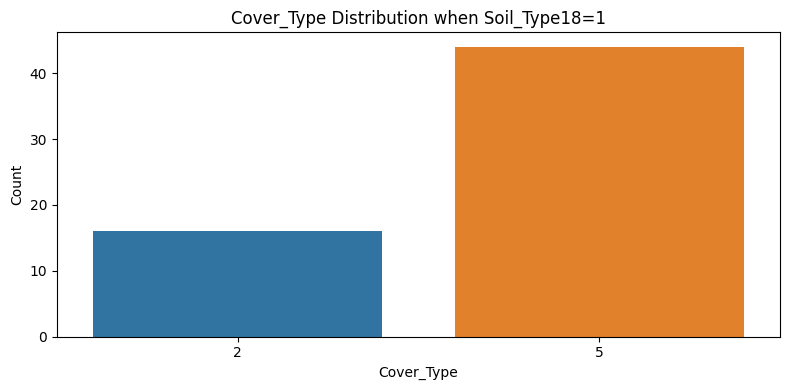

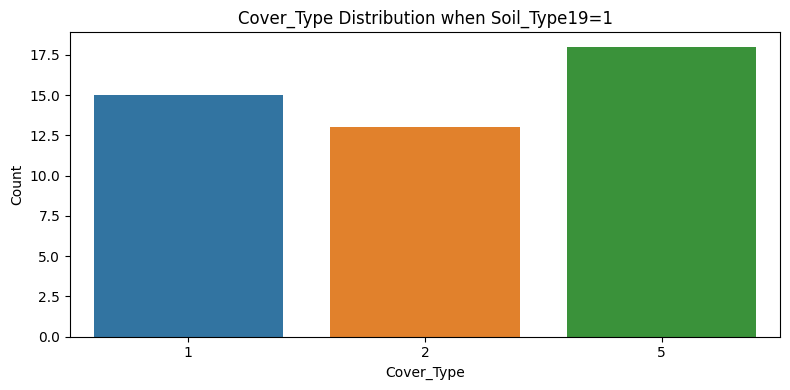

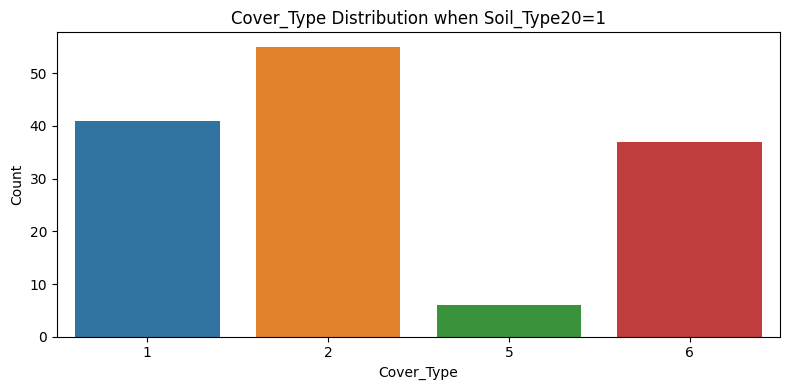

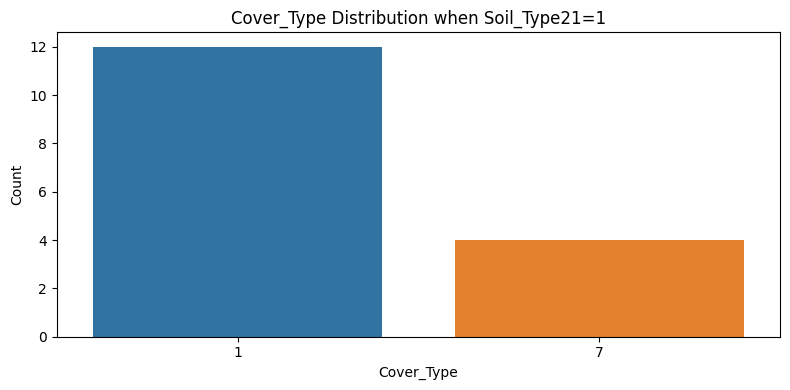

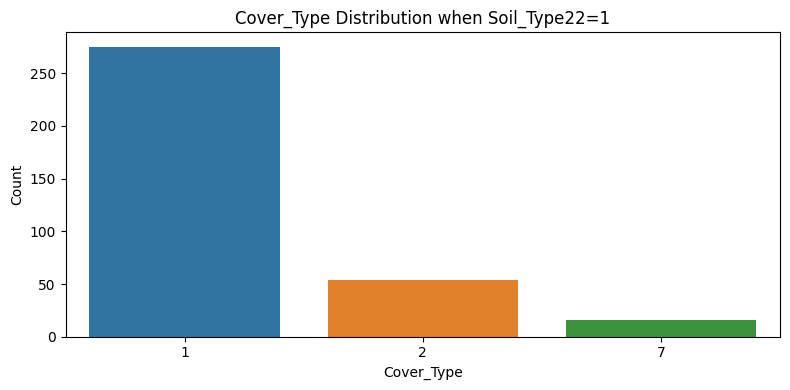

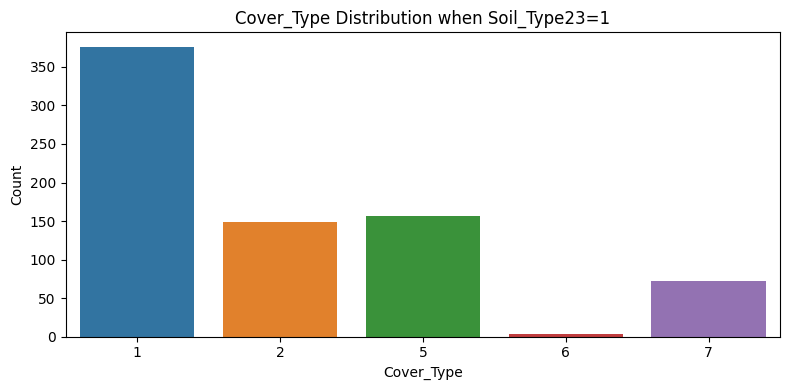

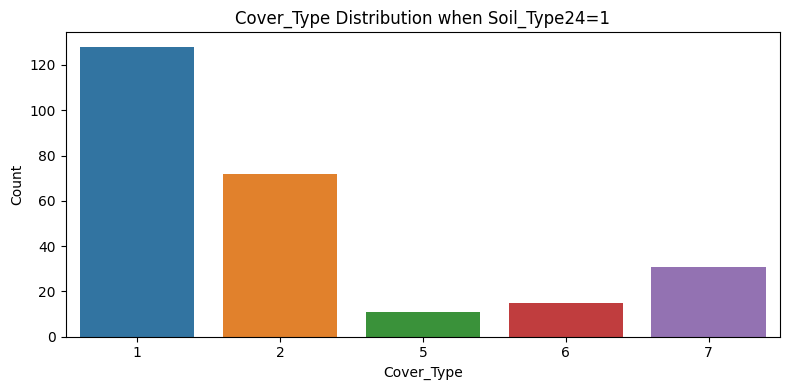

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)


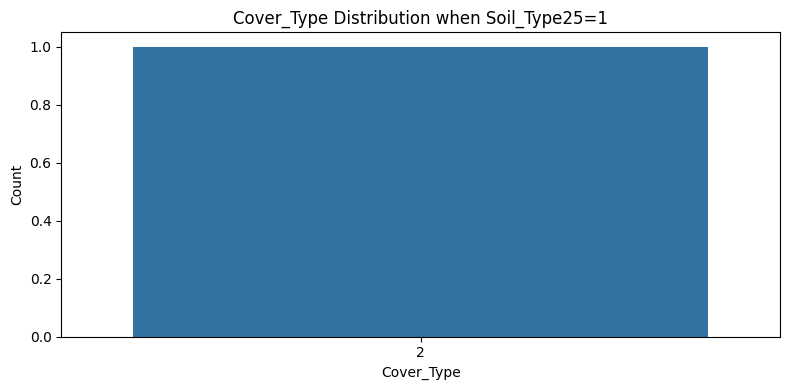

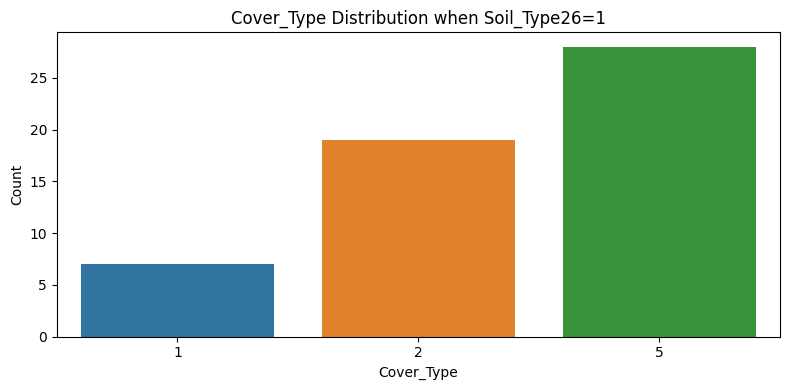

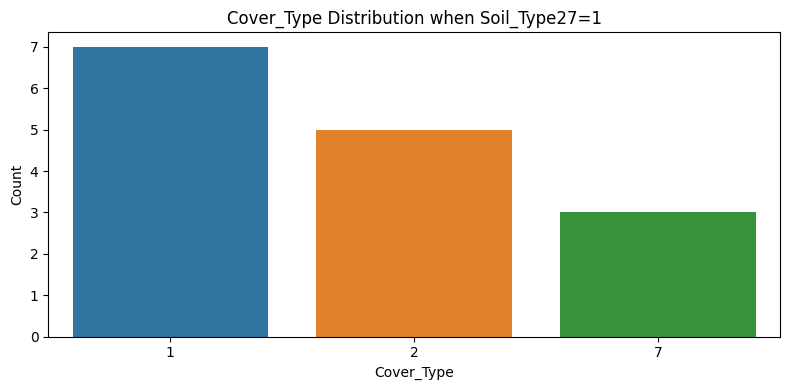

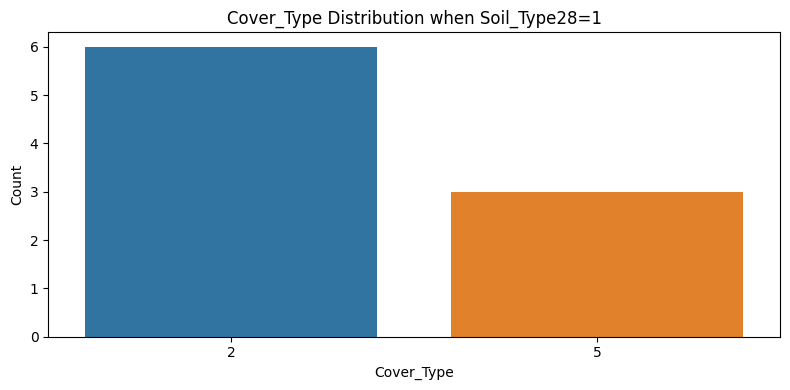

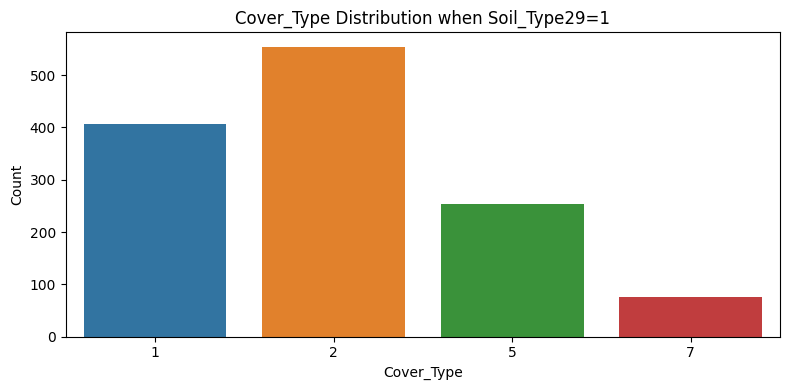

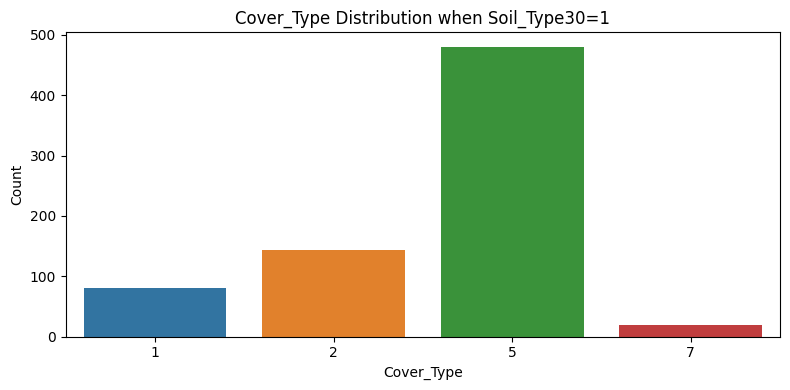

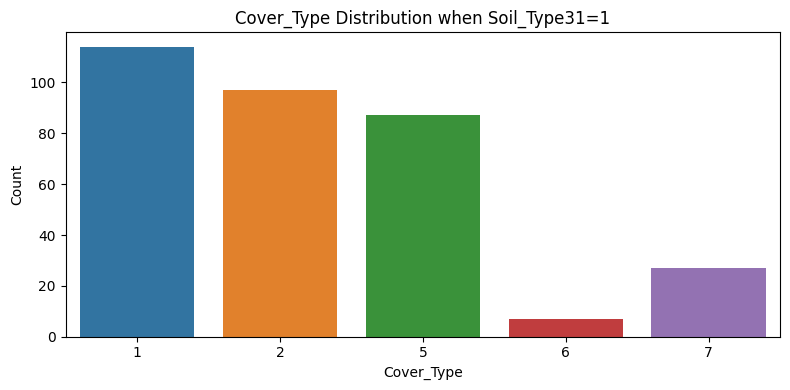

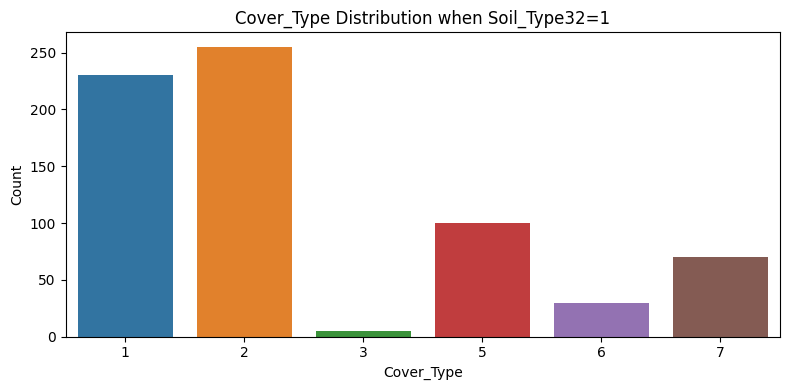

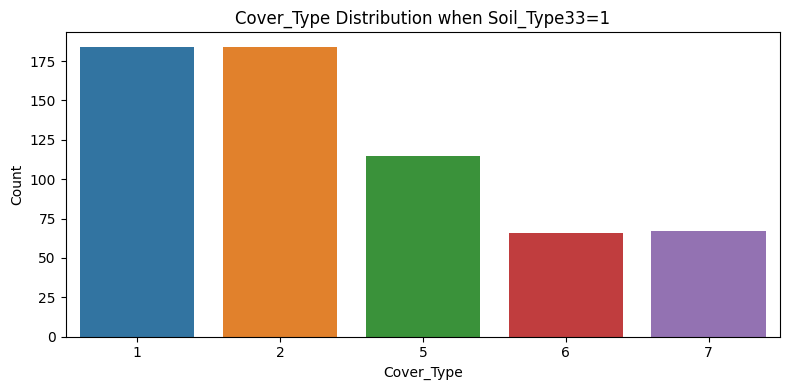

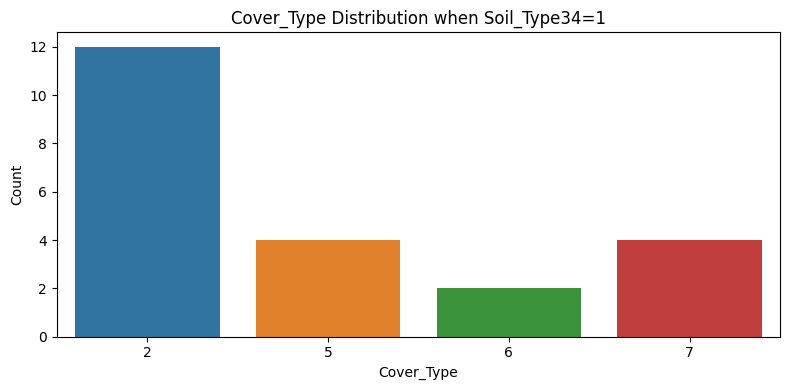

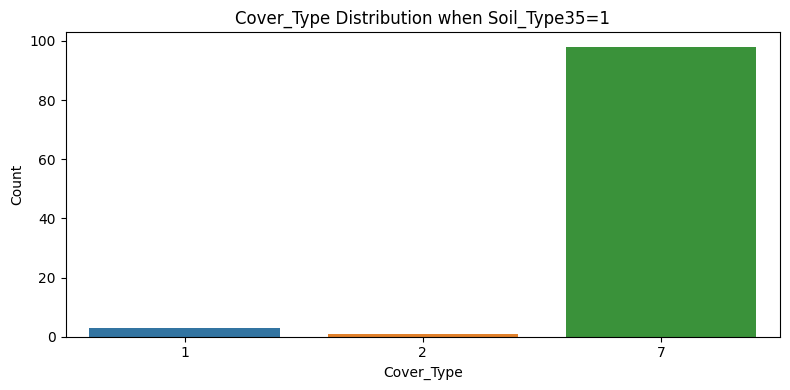

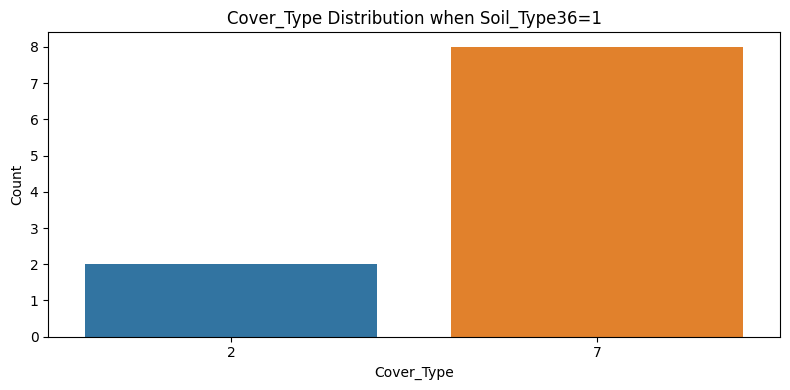

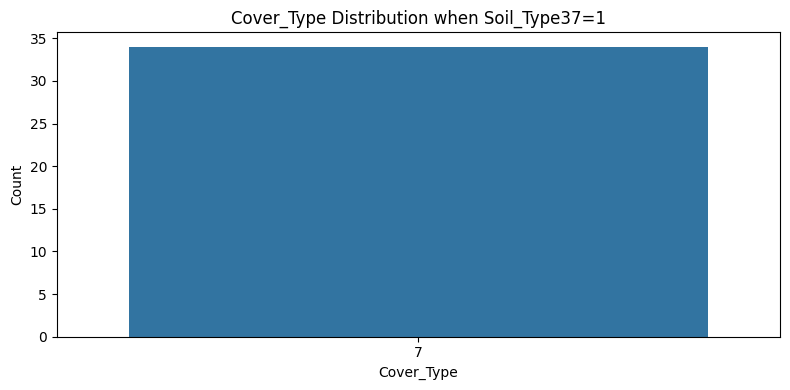

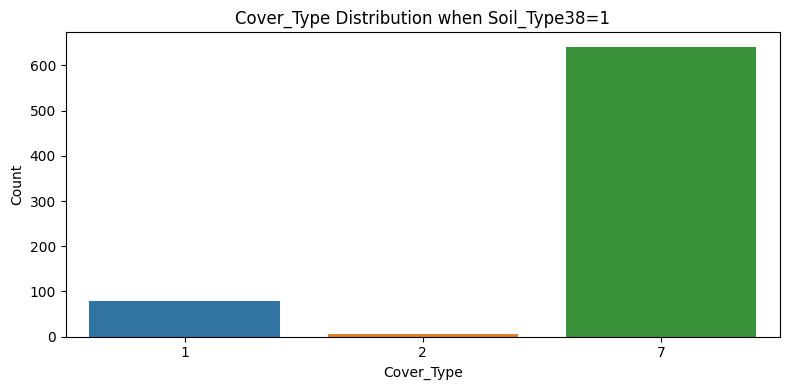

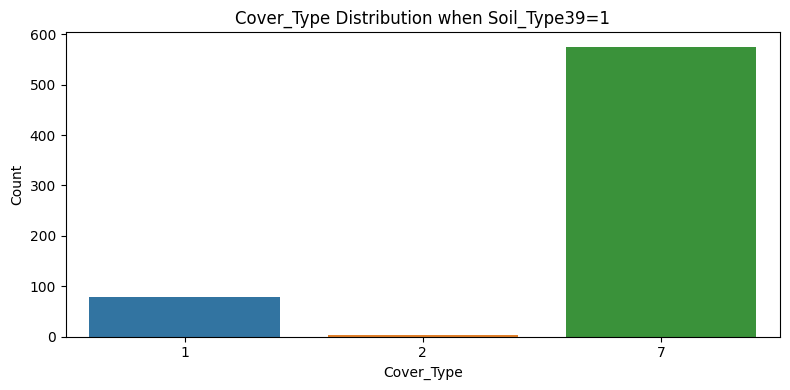

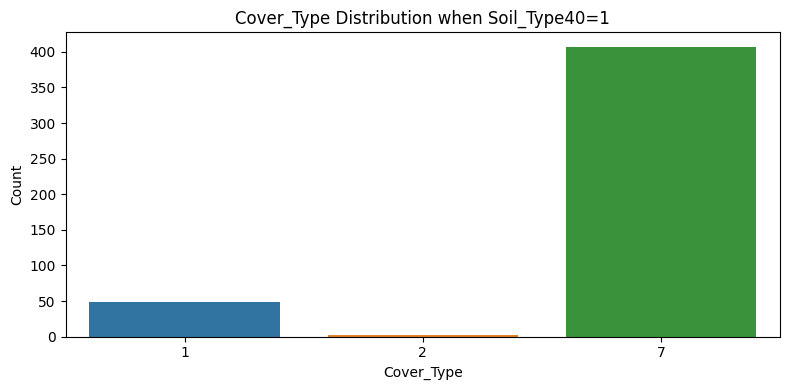

In [14]:
soil_cols = [col for col in categorical_features if "Soil_Type" in col]

for col in soil_cols:
    subset = train[train[col] == 1]
    if subset.empty:
        continue  
    plt.figure(figsize=(8, 4))
    sns.countplot(x='Cover_Type', data=subset)
    plt.title(f"Cover_Type Distribution when {col}=1")
    plt.xlabel("Cover_Type")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


# 각 Soil_Type 별 Cover_Type 분포 시각화
-각 Soil_Type이 활성화되어 있는 레코드만을 추출하여 Cover_Type 분포를 시각화함으로써, 특정 Soil_Type이 어떤 Cover_Type과 연관성이 높은지를 확인

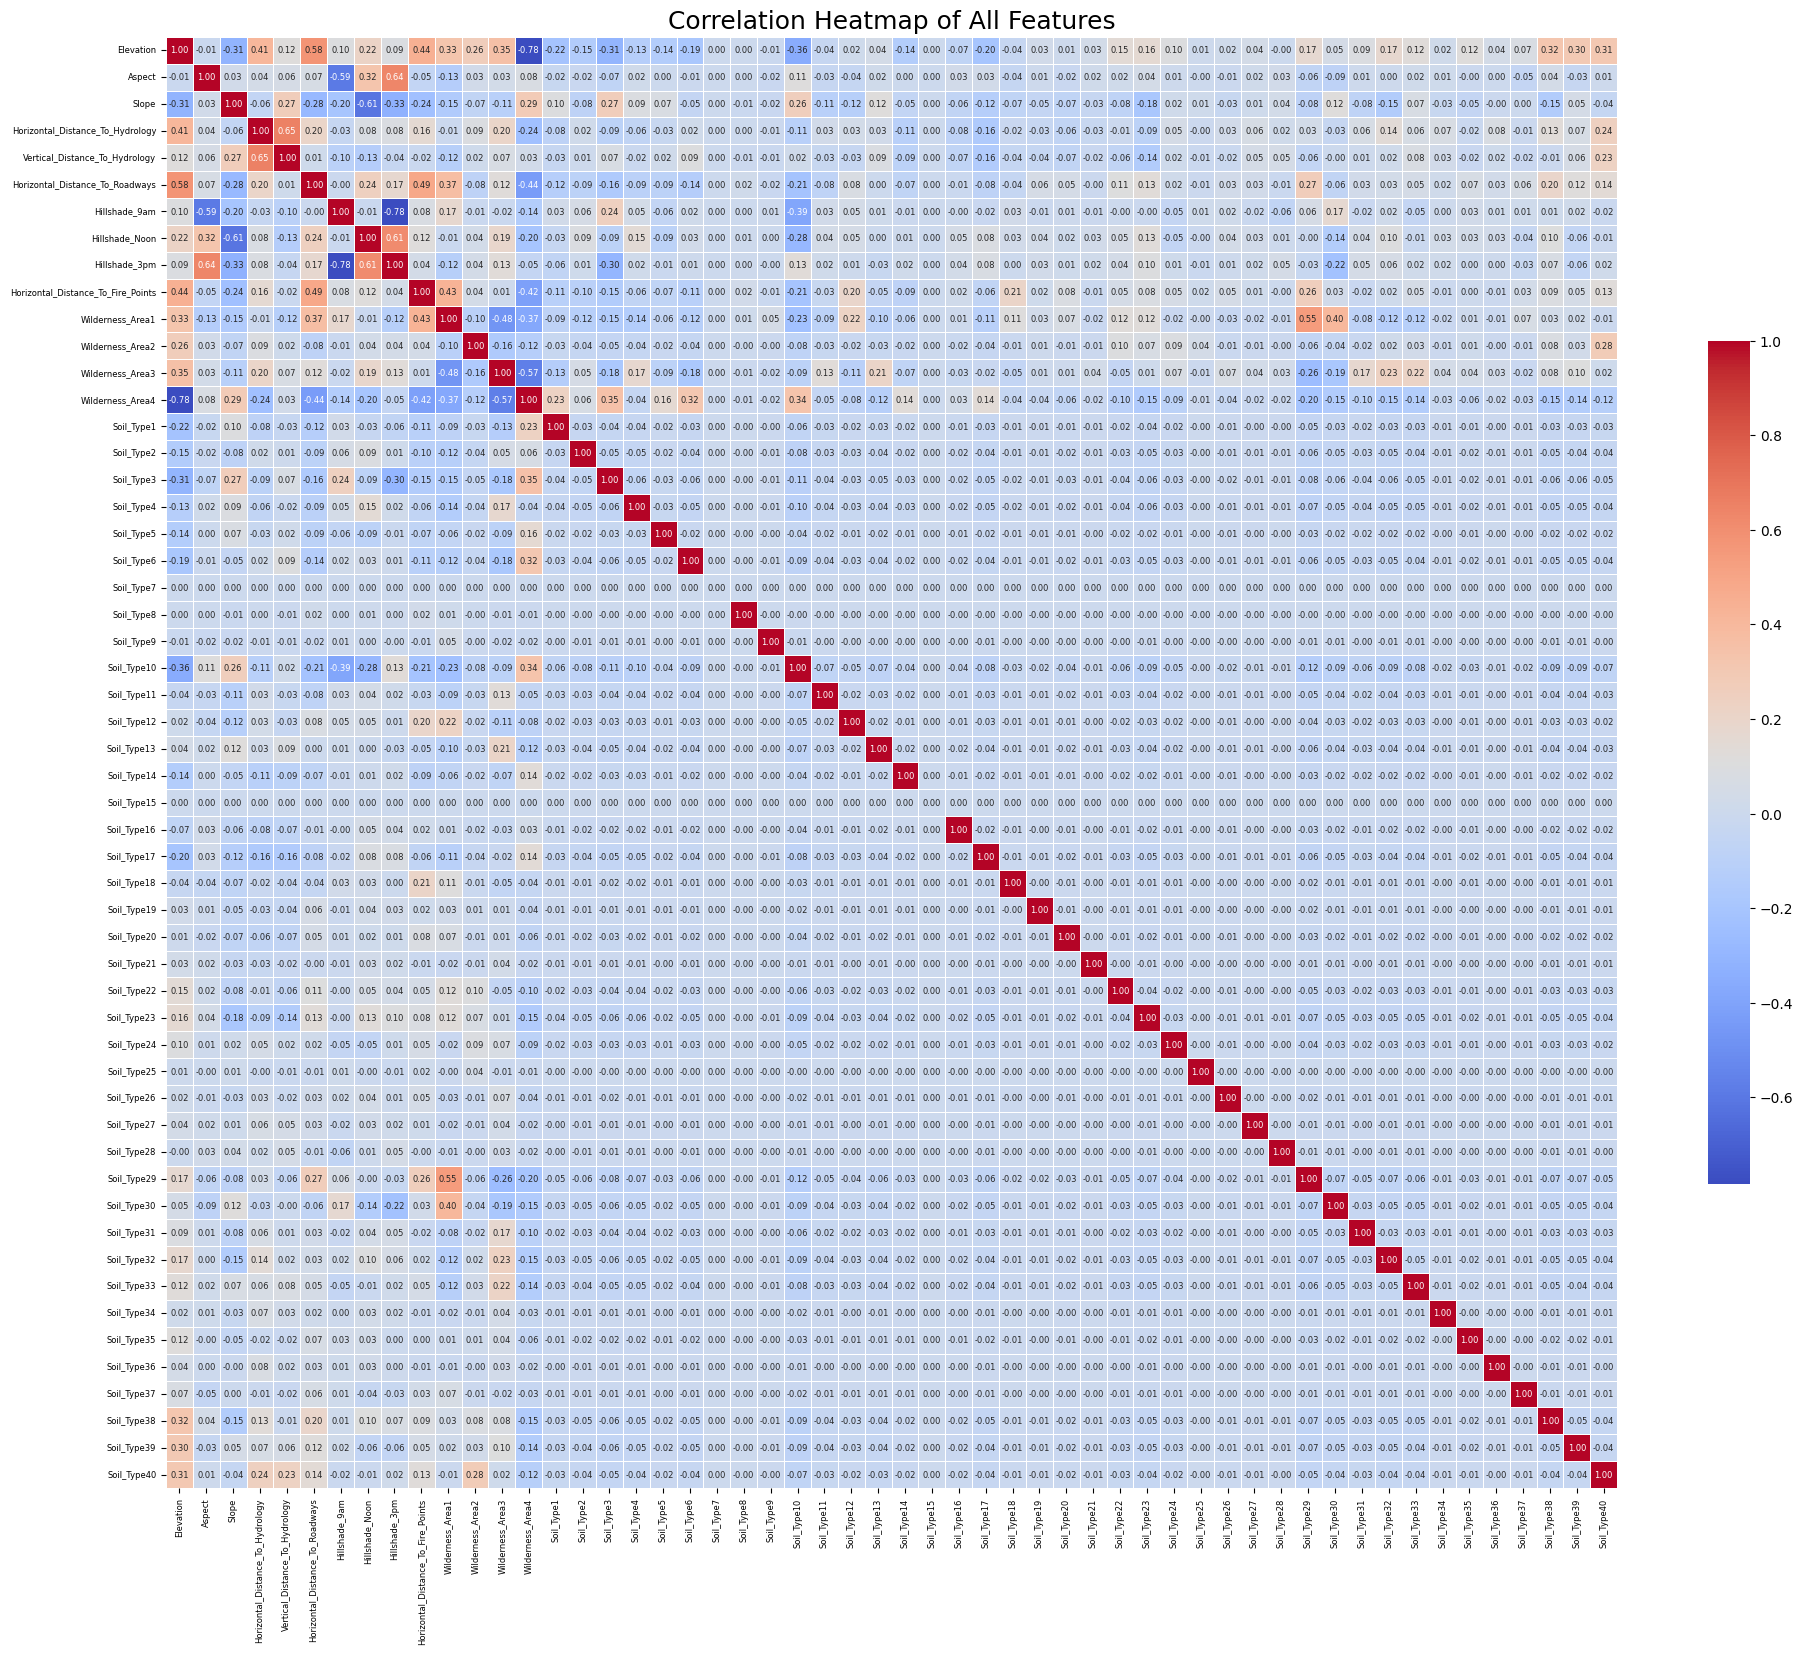

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 상관계수 계산 (Id와 Cover_Type 제외)
cols_to_drop = [col for col in ['Id', 'Cover_Type'] if col in train.columns]
corr_matrix = train.drop(columns=cols_to_drop, errors='ignore').corr().fillna(0)

plt.figure(figsize=(20, 18))  
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 6}, 
    cbar_kws={'shrink': 0.5}  
)
plt.title("Correlation Heatmap of All Features", fontsize=18)
plt.xticks(rotation=90, fontsize=6) 
plt.yticks(rotation=0, fontsize=6)
plt.tight_layout()
plt.show()


# 피처 간 상관관계 분석
- 데이터 셋의 피처를 상관관계 히트맵으로 시각화
- 상관관계를 통해 파생 피쳐 설계 고려

In [16]:
# 이상치 제거
for col in numeric_features:
    q1 = train[col].quantile(0.25)             # 1사분위수 (25%)
    q3 = train[col].quantile(0.75)             # 3사분위수 (75%)
    iqr = q3 - q1                              # IQR (Interquartile Range)

    lower_bound = q1 - 1.5 * iqr               # 이상치 하한
    upper_bound = q3 + 1.5 * iqr               # 이상치 상한

    train = train[(train[col] >= lower_bound) & (train[col] <= upper_bound)]

print("이상치 제거 후 shape:", train.shape)

이상치 제거 후 shape: (12085, 56)


# 이상치 제거
- 모든 수치형 변수에 대해 IQR 방식으로 이상치 제거
- 하한과 상한의 범위를 정하고 범위 바깥에 위치한 값들을 이상치로 간주하고 제거

# 극단적인 값으로 인한 왜곡을 줄여 예측 성능 확보

In [17]:
# 불필요 피처 제거
train = train.drop(columns=['Id'])

# 불피요 피처 제거
- Id 피처의 경우 학습에 관련이 없으므로 피처를 제거

In [18]:
# 파생 피처 생성
def add_features(df):
    df['Hydro_Distance'] = np.sqrt(df['Horizontal_Distance_To_Hydrology']**2 + df['Vertical_Distance_To_Hydrology']**2)
    df['Hillshade_Sum'] = df['Hillshade_9am'] + df['Hillshade_Noon'] + df['Hillshade_3pm']
    df['Hillshade_Range'] = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].max(axis=1) - \
                            df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].min(axis=1)
    df['Elevation_Hydrology'] = df['Elevation'] - df['Vertical_Distance_To_Hydrology']
    df['Elevation_per_Slope'] = df['Elevation'] / (df['Slope'] + 1)
    df['Mean_Horizontal_Distance'] = (
        df['Horizontal_Distance_To_Hydrology'] +
        df['Horizontal_Distance_To_Roadways'] +
        df['Horizontal_Distance_To_Fire_Points']
    ) / 3
    df['Distance_Balance'] = df[['Horizontal_Distance_To_Hydrology',
                                 'Horizontal_Distance_To_Roadways',
                                 'Horizontal_Distance_To_Fire_Points']].max(axis=1) - \
                             df[['Horizontal_Distance_To_Hydrology',
                                 'Horizontal_Distance_To_Roadways',
                                 'Horizontal_Distance_To_Fire_Points']].min(axis=1)
    return df

train = add_features(train)
test = add_features(test)

# 파생 피처 생성
- 지형 정보, 일조량, 거리 정보 등을 바탕으로 파생 피처를 생성(시각화 결과 분석을 통해)

# Hydro_Distance
-수면과의 거리 두 변수(Horizontal, Vertical)의 거리 관계 통합
# Hillshade_Sum
- 하루 일조량 총합
# Hillshade_Range
- 하루 일조량 변화 범위
# Elevation_Hydrology
- 수면 기준 상대 고도
# Elevation_per_Slope
- 고도 대비 경사 비율
# Mean_Horizontal_Distance
- 수계, 도로, 화재지점까지의 평균거리
# Distance_Balance
- 세 수평 거리 간 최대/최소 차이

In [19]:
from sklearn.preprocessing import StandardScaler
scaled_cols = [col for col in train.columns if col not in categorical_features + ['Cover_Type']]
scaler = StandardScaler()
train[scaled_cols] = scaler.fit_transform(train[scaled_cols])


# 수치형 피처 스케일링
- 수치형 피쳐들에 대해 표준화 수행(Cover_Type을 제외)

In [20]:
import optuna
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from xgboost import XGBClassifier

# 평가 함수 정의
def evaluate_model(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# 데이터 분할
X = train.drop(columns=['Cover_Type'])
y = train['Cover_Type'] - 1
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

# RandomForest Optuna 
def rf_objective(trial): 
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 400, step=100),
        'max_depth': trial.suggest_categorical('max_depth', [10, 20, 30, 40, None]),
        'min_samples_split': trial.suggest_categorical('min_samples_split', [2, 5, 10]),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'n_jobs': -1,
        'random_state': 0,
    }

    model = RandomForestClassifier(**params)  # 💡 오타: odel → model 수정
    return cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=30)
best_rf = RandomForestClassifier(**rf_study.best_trial.params)
best_rf.fit(X_train, y_train)


# XGBoost Optuna 
def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 400, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'use_label_encoder': False,  # 💡 경고 방지용
        'eval_metric': 'mlogloss',
        'n_jobs': -1,
        'random_state': 0,
    }
    model = XGBClassifier(**params)
    return cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(xgb_objective, n_trials=30)
best_xgb = XGBClassifier(**xgb_study.best_trial.params, use_label_encoder=False, eval_metric='mlogloss')
best_xgb.fit(X_train, y_train)


# 최적 하이퍼파라미터로 앙상블 모델 훈련 및 예측
rf_best_params = rf_study.best_trial.params
xgb_best_params = xgb_study.best_trial.params

rf_model = RandomForestClassifier(**rf_best_params)
xgb_model = XGBClassifier(**xgb_best_params, use_label_encoder=False, eval_metric='mlogloss')

ensemble_model = VotingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model)],
    voting='soft',  
    n_jobs=-1
)

ensemble_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = ensemble_model.predict(X_val)
evaluate_model(y_val, y_pred)



# 최적 하이퍼파라미터 출력
print("Best RandomForest Hyperparameters:", rf_best_params)
print("Best XGBoost Hyperparameters:", xgb_best_params)

[I 2025-06-08 12:32:49,073] A new study created in memory with name: no-name-a1798725-bd93-4dbc-b5f5-72c9665b27bb
[I 2025-06-08 12:32:53,670] Trial 0 finished with value: 0.8493983825261033 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8493983825261033.
[I 2025-06-08 12:33:02,514] Trial 1 finished with value: 0.8480539115166774 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8493983825261033.
[I 2025-06-08 12:33:16,112] Trial 2 finished with value: 0.8484676689790505 and parameters: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8493983825261033.
[I 2025-06-08 12:33:24,848] Trial 3 finished with value: 0.8411235542696893 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 10, 'max_features': 'sqrt'}. Best is trial 0

Accuracy: 0.8833264377327266
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80       306
           1       0.78      0.69      0.73       303
           2       0.89      0.86      0.88       354
           3       0.95      0.99      0.97       406
           4       0.89      0.94      0.92       359
           5       0.86      0.89      0.87       384
           6       0.94      0.98      0.96       305

    accuracy                           0.88      2417
   macro avg       0.88      0.88      0.88      2417
weighted avg       0.88      0.88      0.88      2417

Confusion Matrix:
 [[237  49   0   0   4   0  16]
 [ 44 208   6   0  32  10   3]
 [  0   0 306   6   2  40   0]
 [  0   0   1 403   0   2   0]
 [  1   9   6   0 339   4   0]
 [  0   1  25  13   3 342   0]
 [  5   0   0   0   0   0 300]]
Best RandomForest Hyperparameters: {'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 2, 'max_features':

# Optuna 기반 RandomForest + XGBoost 앙상블 모델 최적화 및 평가
- RandomForest + XGBoost 두 모델의 하이퍼파라미터를 Optuna로 최적화하고 최적화된 두 모델을 앙상블하여 성능을 향상

# 데이터 분할
# Optuna로 RandomForest 최적화
- 튜닝 대상: `n_estimators`, `max_depth`, `min_samples_split`, `max_features`
- 평가 지표: 5-fold 교차 검증의 `accuracy` 평균
# Optuna로 XGBoost 최적화
- 튜닝 대상: `n_estimators`, `max_depth`, `learning_rate`, `subsample`, `colsample_bytree`, `gamma`
- 평가 지표: 5-fold `accuracy`
# soft voting으로 앙상블
# 검증 데이터로 평가
# 하이퍼파리미터 최적화 결과 출력

In [21]:
test = pd.read_csv("/kaggle/input/forest-cover-type-prediction/test.csv")
submission = pd.read_csv("/kaggle/input/forest-cover-type-prediction/sampleSubmission.csv")

test = add_features(test)

test[scaled_cols] = scaler.transform(test[scaled_cols])


test_pred = ensemble_model.predict(test.drop(columns=['Id'])) + 1
submission['Cover_Type'] = test_pred
submission.to_csv("submission.csv", index=False)

In [22]:
print("제출 파일 생성 완료 → 'submission.csv'")
print("현재 디렉토리 파일 목록:", os.listdir())

제출 파일 생성 완료 → 'submission.csv'
현재 디렉토리 파일 목록: ['submission.csv', '.virtual_documents']
